In [1]:
!pip install shap openpyxl seaborn scikit-learn --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
file_path = "Road Accident Data.xlsx"
df = pd.read_excel(file_path)

print("Shape:", df.shape)
df.head()

Shape: (307973, 21)


,Accident_Index,Accident Date,Day_of_Week,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,Local_Authority_(District),Carriageway_Hazards,...,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
0,BS0000001,2021-01-01,Thursday,Give way or uncontrolled,T or staggered junction,Serious,51.512273,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,One way street,30,15:11:00,Urban,Fine no high winds,Car
1,BS0000002,2021-01-05,Monday,Give way or uncontrolled,Crossroads,Serious,51.514399,Daylight,Kensington and Chelsea,NaN,...,11,2,Metropolitan Police,Wet or damp,Single carriageway,30,10:59:00,Urban,Fine no high winds,Taxi/Private hire car
2,BS0000003,2021-01-04,Sunday,Give way or uncontrolled,T or staggered junction,Slight,51.486668,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,Single carriageway,30,14:19:00,Urban,Fine no high winds,Taxi/Private hire car
3,BS0000004,2021-01-05,Monday,Auto traffic signal,T or staggered junction,Serious,51.507804,Daylight,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Frost or ice,Single carriageway,30,08:10:00,Urban,Other,Motorcycle over 500cc
4,BS0000005,2021-01-06,Tuesday,Auto traffic signal,Crossroads,Serious,51.482076,Darkness - lights lit,Kensington and Chelsea,NaN,...,1,2,Metropolitan Police,Dry,Single carriageway,30,17:25:00,Urban,Fine no high winds,Car


In [4]:
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()
df.columns

Index(['accident_index', 'accident_date', 'day_of_week', 'junction_control',
       'junction_detail', 'accident_severity', 'latitude', 'light_conditions',
       'local_authority_(district)', 'carriageway_hazards', 'longitude',
       'number_of_casualties', 'number_of_vehicles', 'police_force',
       'road_surface_conditions', 'road_type', 'speed_limit', 'time',
       'urban_or_rural_area', 'weather_conditions', 'vehicle_type'],
      dtype='object')

In [5]:
# Try converting date column automatically
for col in df.columns:
    if "date" in col:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        date_col = col
        break

# Create time-based features
df["hour"] = df[date_col].dt.hour
df["dayofweek"] = df[date_col].dt.dayofweek
df["month"] = df[date_col].dt.month
df["is_weekend"] = df["dayofweek"].isin([5,6]).astype(int)

df.head()

,accident_index,accident_date,day_of_week,junction_control,junction_detail,accident_severity,latitude,light_conditions,local_authority_(district),carriageway_hazards,...,road_type,speed_limit,time,urban_or_rural_area,weather_conditions,vehicle_type,hour,dayofweek,month,is_weekend
0,BS0000001,2021-01-01,Thursday,Give way or uncontrolled,T or staggered junction,Serious,51.512273,Daylight,Kensington and Chelsea,NaN,...,One way street,30,15:11:00,Urban,Fine no high winds,Car,0,4,1,0
1,BS0000002,2021-01-05,Monday,Give way or uncontrolled,Crossroads,Serious,51.514399,Daylight,Kensington and Chelsea,NaN,...,Single carriageway,30,10:59:00,Urban,Fine no high winds,Taxi/Private hire car,0,1,1,0
2,BS0000003,2021-01-04,Sunday,Give way or uncontrolled,T or staggered junction,Slight,51.486668,Daylight,Kensington and Chelsea,NaN,...,Single carriageway,30,14:19:00,Urban,Fine no high winds,Taxi/Private hire car,0,0,1,0
3,BS0000004,2021-01-05,Monday,Auto traffic signal,T or staggered junction,Serious,51.507804,Daylight,Kensington and Chelsea,NaN,...,Single carriageway,30,08:10:00,Urban,Other,Motorcycle over 500cc,0,1,1,0
4,BS0000005,2021-01-06,Tuesday,Auto traffic signal,Crossroads,Serious,51.482076,Darkness - lights lit,Kensington and Chelsea,NaN,...,Single carriageway,30,17:25:00,Urban,Fine no high winds,Car,0,2,1,0


In [6]:
# Normalize casualties if exists
if "casualties" in df.columns:
    df["casualties"] = df["casualties"].fillna(0)
else:
    df["casualties"] = 0

# Night indicator
df["is_night"] = df["hour"].apply(lambda x: 1 if (x>=19 or x<=6) else 0)

# Risk Score
df["risk_score"] = (
    df["casualties"] * 2 +
    df["is_night"] * 1
)

# Risk Category
df["risk_level"] = pd.cut(df["risk_score"],
                          bins=[-1,2,5,100],
                          labels=["Low","Medium","High"])

df[["risk_score","risk_level"]].head()

,risk_score,risk_level
0,1,Low
1,1,Low
2,1,Low
3,1,Low
4,1,Low


In [7]:
target_col = "accident_severity"

le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col])

print(dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))

{'Fatal': 0, 'Fetal': 1, 'Serious': 2, 'Slight': 3}


In [8]:
features = [
    "latitude",
    "longitude",
    "hour",
    "dayofweek",
    "month",
    "is_weekend",
    "is_night",
    "casualties"
]

# Keep only existing columns
features = [f for f in features if f in df.columns]

X = df[features].fillna(0)
y = df[target_col]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8345644938712558

Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.01      0.02       781
           1       0.00      0.00      0.00        10
           2       0.15      0.03      0.06      8148
           3       0.86      0.97      0.91     52656

    accuracy                           0.83     61595
   macro avg       0.27      0.25      0.25     61595
weighted avg       0.75      0.83      0.79     61595



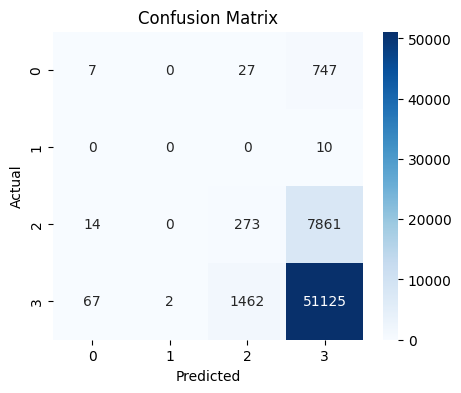

In [11]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

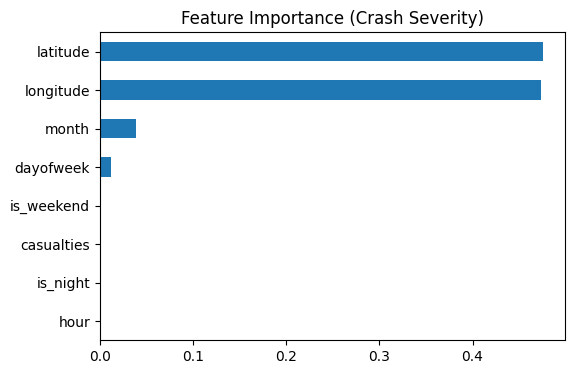

In [12]:
importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values().plot(kind="barh", figsize=(6,4))
plt.title("Feature Importance (Crash Severity)")
plt.show()

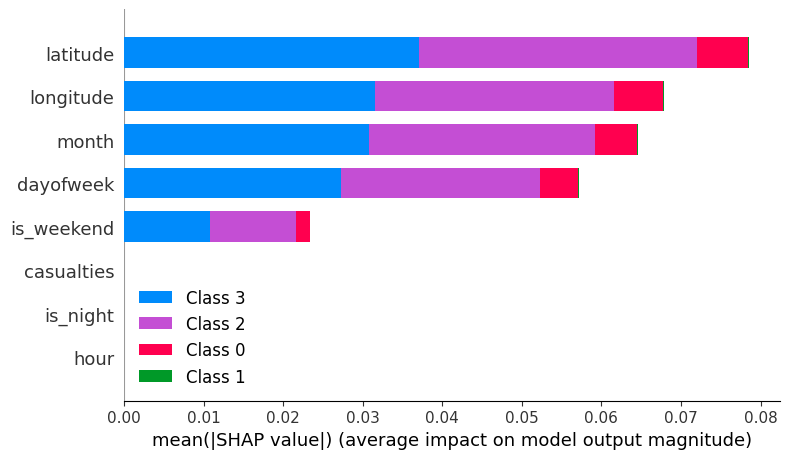

In [13]:
import shap

explainer = shap.TreeExplainer(model)
X_sample = X_test.sample(min(200, len(X_test)), random_state=42)
shap_values = explainer.shap_values(X_sample)

# For multi-class safe plotting
try:
    shap.summary_plot(shap_values, X_sample)
except:
    shap.summary_plot(shap_values[1], X_sample)

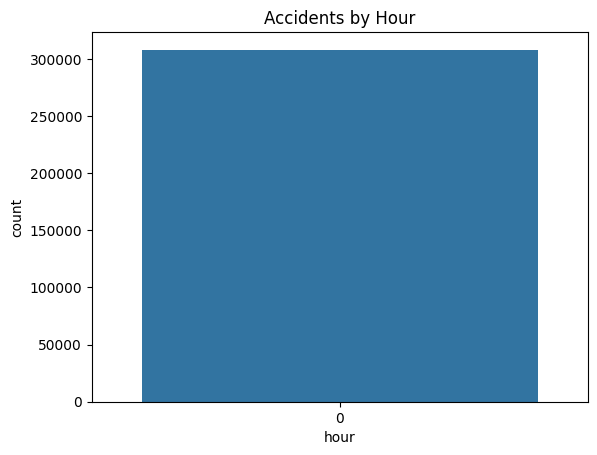

In [14]:
sns.countplot(x=df["hour"])
plt.title("Accidents by Hour")
plt.show()

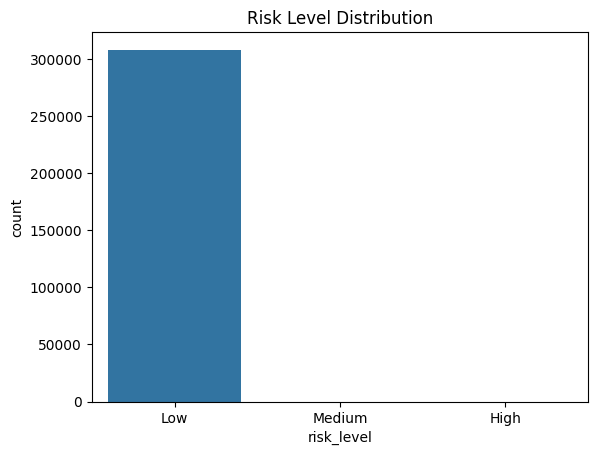

In [15]:
sns.countplot(x=df["risk_level"])
plt.title("Risk Level Distribution")
plt.show()

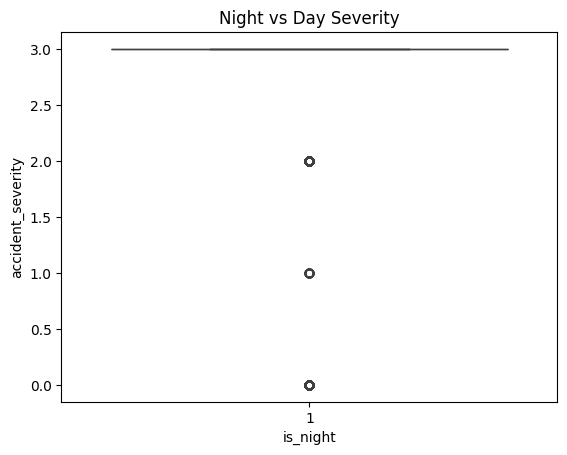

In [16]:
sns.boxplot(x=df["is_night"], y=df[target_col])
plt.title("Night vs Day Severity")
plt.show()

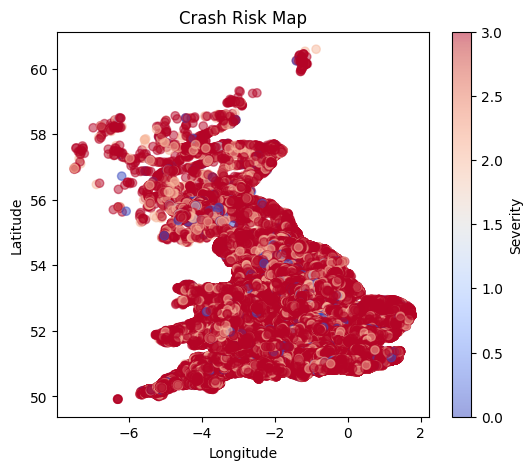

In [17]:
plt.figure(figsize=(6,5))
plt.scatter(df["longitude"], df["latitude"],
            c=df[target_col], cmap="coolwarm", alpha=0.5)
plt.colorbar(label="Severity")
plt.title("Crash Risk Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()